In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-sentences-100k/Translation_2.csv
/kaggle/input/sentence-gpt-v2-3.5m/pytorch/default/1/GPT_Params_v1.pth


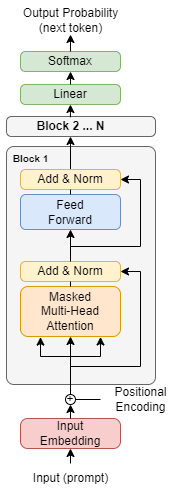
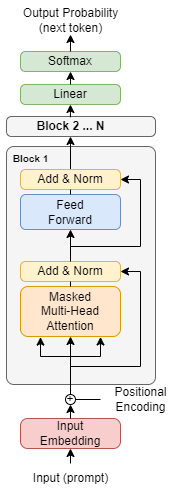

In [2]:
import os
import re
import torch
import warnings
from pathlib import Path
from tqdm import tqdm
from collections import Counter

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR

from transformers import BertTokenizer
from tokenizers import Tokenizer

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}\n")

    for i in range(num_devices):
        print(f"--- Device {i} Info ---")
        print(f"Name: {torch.cuda.get_device_name(i)}")
        print(f"Capability: {torch.cuda.get_device_capability(i)}")
        print(f"Memory Allocated: {round(torch.cuda.memory_allocated(i)/1024**3, 2)} GB")
        print(f"Memory Reserved: {round(torch.cuda.memory_reserved(i)/1024**3, 2)} GB")
        print()
else:
    print("CUDA is not available on this machine.")

Number of CUDA devices: 1

--- Device 0 Info ---
Name: Tesla P100-PCIE-16GB
Capability: (6, 0)
Memory Allocated: 0.0 GB
Memory Reserved: 0.0 GB



In [4]:
df = pd.read_csv("//kaggle//input//english-sentences-100k//Translation_2.csv")

In [5]:
df

,Sentences
0,I have to go to sleep.
1,Today is June 18th and it is Muiriel's birthday!
2,Muiriel is 20 now.
3,"The password is ""Muiriel""."
4,I will be back soon.
...,...
99995,His success was in part due to luck.
99996,He owes much of his success to his wife.
99997,I have no doubt that he will succeed.
99998,His success was nothing short of a miracle.


In [6]:
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

df['Sentences'] = df['Sentences'].apply(clean_text)

In [7]:
df

,Sentences
0,I have to go to sleep
1,Today is June 18th and it is Muiriels birthday
2,Muiriel is 20 now
3,The password is Muiriel
4,I will be back soon
...,...
99995,His success was in part due to luck
99996,He owes much of his success to his wife
99997,I have no doubt that he will succeed
99998,His success was nothing short of a miracle


In [8]:
df['Sentences'] = df['Sentences'].str.lower()

In [9]:
df

,Sentences
0,i have to go to sleep
1,today is june 18th and it is muiriels birthday
2,muiriel is 20 now
3,the password is muiriel
4,i will be back soon
...,...
99995,his success was in part due to luck
99996,he owes much of his success to his wife
99997,i have no doubt that he will succeed
99998,his success was nothing short of a miracle


In [10]:
df = df[df['Sentences'].str.match(r'^[A-Za-z\s]+$')]
print(df)

                                        Sentences
0                           i have to go to sleep
3                         the password is muiriel
4                             i will be back soon
5                          im at a loss for words
6                      this is never going to end
...                                           ...
99995         his success was in part due to luck
99996     he owes much of his success to his wife
99997        i have no doubt that he will succeed
99998  his success was nothing short of a miracle
99999              his success is out of question

[98291 rows x 1 columns]


In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab_count = Counter()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Iterate through each sentence and tokenize
for sentence in df['Sentences']:  # Replace 'sentence' with your actual column name
    tokens = tokenizer.tokenize(sentence)
    vocab_count.update(tokens)

# Get the unique tokens used
used_tokens = list(vocab_count.keys())
print(f"Number of unique tokens used: {len(used_tokens)}")

Number of unique tokens used: 15047


In [13]:
original_vocab = tokenizer.get_vocab()
reindexed_vocab = {token: idx for idx, token in enumerate(used_tokens)}

with open("reindexed_vocab.txt", "w", encoding="utf-8") as f:
    for token in reindexed_vocab:
        f.write(token + "\n")

print(f"Reindexed vocabulary size: {len(reindexed_vocab)}")

Reindexed vocabulary size: 15047


In [14]:
print("Original vocab size:", len(tokenizer.get_vocab()))

Original vocab size: 30522


In [15]:
custom_tokenizer = BertTokenizer(vocab_file="reindexed_vocab.txt")

In [16]:
print("Reduced vocab size :",len(custom_tokenizer.get_vocab()))

Reduced vocab size : 15052


In [17]:
# Print all special tokens of the custom tokenizer
print("All Special Tokens:")
print(custom_tokenizer.special_tokens_map)

print("\nSpecial Tokens IDs:")
for token_name, token in custom_tokenizer.special_tokens_map.items():
    token_id = custom_tokenizer.convert_tokens_to_ids(token)
    print(f"{token_name}: '{token}' -> ID: {token_id}")

All Special Tokens:
{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}

Special Tokens IDs:
unk_token: '[UNK]' -> ID: 15047
sep_token: '[SEP]' -> ID: 15048
pad_token: '[PAD]' -> ID: 15049
cls_token: '[CLS]' -> ID: 15050
mask_token: '[MASK]' -> ID: 15051


In [18]:
df = df.copy()
df['Tokenized'] = df['Sentences'].apply(lambda x: custom_tokenizer.encode(x))
df['count'] = df['Tokenized'].apply(lambda x: len(x))

In [19]:
needed_rows = []
j = 0
for idx, i in enumerate(df['count']):
    if i > 6 and i < 16:
        needed_rows.append(idx)
        j += 1
print(j/98291)
print(j)
print(len(needed_rows))

0.8741390361274176
85920
85920


In [20]:
df2 = df.iloc[needed_rows]

In [21]:
df2 = df2.copy()
df2['target'] = df2['Tokenized'].apply(lambda x: x[1:])
df2['input'] = df2['Tokenized'].apply(lambda x: x[:-1])

In [22]:
max_len = 16
 
def pad_sequence(tokens, max_len):

    if len(tokens) < max_len:
        tokens.extend([15049] * (max_len - len(tokens)))
    # Truncate if it's longer than max_len
    else:
       tokens = tokens[:max_len]
    if len(tokens) != max_len:
        print(len(tokens))
    return tokens

In [23]:
df2 = df2.copy()
df2['Padded_source'] = df2['input'].apply(lambda x: pad_sequence(x, max_len = 16 ))
df2['Padded_target'] = df2['target'].apply(lambda x: pad_sequence(x, max_len = 16 ))

In [24]:
import torch
from torch.utils.data import Dataset


class GPTDataset(Dataset):
    def __init__(self, dataframe, pad_token=15049):
        self.dataframe = dataframe
        self.pad_token = pad_token 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the tokenized sequences for English and Tamil
        text =  self.dataframe.iloc[idx]["Sentences"]
        source_tokens =  torch.tensor(self.dataframe.iloc[idx]["Padded_source"],  dtype=torch.long) 
        target_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_target"],  dtype=torch.long)   

        def causal_mask(size):
              mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
              return mask == 0
    # Return the sequence and masks in a dictionary
        return {
            "source": text,
            "source_tokens": source_tokens.clone(),
            "target_tokens": target_tokens.clone(),
            "decoder_mask": (target_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(target_tokens.size(0)).clone(),

        }

In [25]:
dataset = GPTDataset(df2) 
train_dataloader = DataLoader(dataset, batch_size = 64, shuffle=True)  

In [26]:
for batch_idx, batch in enumerate(train_dataloader):
    # Check the shapes of each tensor in the batch
    print(f"  text sequence shape: {batch['source'][0]}") 
    print(f"  source_tokens sequence shape: {batch['source_tokens'].shape}") 
    print(f"  target_tokens token shape: {batch['target_tokens'].shape}") 
    print(f"  Combined Tamil mask shape: {batch['decoder_mask'].shape}") 
    break

  text sequence shape: which of you came here first
  source_tokens sequence shape: torch.Size([64, 16])
  target_tokens token shape: torch.Size([64, 16])
  Combined Tamil mask shape: torch.Size([64, 1, 16, 16])


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tgt_vocab_size = len(custom_tokenizer.get_vocab())
d_model = 128
n_heads = 8
d_ff = 512
n_dec_layers = 8
dropout = 0.1

import torch.nn as nn
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # Embedding vector size
        self.h = h  # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h  # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False)  # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False)  # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False)  # Wo
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask):
        # Apply linear transformations to the inputs
        query = self.w_q(q)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # Reshape to (batch, seq_len, h, d_k) and then transpose to (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        mask = mask.to(torch.bool) 
        attn_output = F.scaled_dot_product_attention(query, key, value, attn_mask=mask)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(attn_output.shape[0], -1, self.h * self.d_k)
        output = self.w_o(attn_output)
        return output



class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)
        
        self.fc_out.weight = self.embedding.weight

    def forward(self, tgt, tgt_mask):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, tgt_mask)
        return self.fc_out(x)
  
model = Transformer(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout).to(device)
print(f"Total model parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cuda
Total model parameters: 3523788


In [28]:
def causal_mask(size):
    """Look ahead mask or attention mask"""
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

def top_k_sampling(logits, k):
    top_k_probs, top_k_indices = torch.topk(logits, k, dim=-1)
    top_k_probs = F.softmax(top_k_probs, dim=-1)
    sampled_index = torch.multinomial(top_k_probs, 1)
    next_word = top_k_indices.gather(-1, sampled_index)
    return next_word.squeeze()

def decode(model, max_len, device, k=5):
    """returns the decoded tensor (token ids)"""
    cls_idx, sep_idx = 15050,15048
    model_input = torch.empty(1, 1, dtype=torch.int64).fill_(cls_idx).to(device)

    while model_input.size(1) < max_len:
        decoder_mask = causal_mask(model_input.size(1)).to(torch.int64).to(device)
        out = model(model_input, decoder_mask)
        logits = out[:, -1, :]  # Get the logits of the last token
        # Use top-k sampling to select the next word
        next_word = top_k_sampling(logits, k)
        if next_word == sep_idx:
            break
        model_input = torch.cat([model_input, next_word.view(1, 1).to(device)], dim=1)
    return model_input.squeeze(0)[1:]

In [29]:
epochs = 10
lr = 10**-4
batch_size = 32
k = 10
save_checkpoint = "/kaggle/working/GPT_Params_v2.pth"
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

def run_validation(model, k, custom_tokenizer, max_len, device, print_msg):
    model.to(device)
    model.eval()

    try:
      console_width = os.get_terminal_size().columns
    except OSError:
      console_width = 80

    model_out = decode(model, max_len, device, k)
    model_out_text = custom_tokenizer.decode(model_out.detach().cpu().numpy(), skip_special_tokens=True)
    print_msg(f"{'PREDICTED:':>12}{model_out_text}\n{'-'*console_width}")

def train_model():
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if device == 'cuda':
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")

    checkpoint_path = "/kaggle/input/sentence-gpt-v2-3.5m/pytorch/default/1/GPT_Params_v1.pth"
    
    initial_epoch = 0

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-9)
    loss_fn = nn.CrossEntropyLoss(ignore_index=15049).to(device)

    # Load checkpoint if available
    if os.path.exists(checkpoint_path):
        print("Checkpoint found. Loading model and optimizer state...")
        checkpoint = torch.load(checkpoint_path ,map_location = device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initial_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Model loaded from checkpoint. Resuming from epoch {initial_epoch + 1}.")
    else:
        print("Checkpoint not found. Training from scratch.")

    for epoch in range(initial_epoch, initial_epoch + epochs):
        torch.cuda.empty_cache()
        model.train()

        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch+1:02d}")
        for batch in batch_iterator:
            input = batch['source_tokens'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            output = model(input, decoder_mask)

            label = batch['target_tokens'].to(device)

            loss = loss_fn(output.view(-1, len(custom_tokenizer.get_vocab())), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Save model checkpoint with epoch number and optimizer state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_checkpoint)

        print(f"Checkpoint saved at epoch {epoch + 1}.")
        run_validation(model,k, custom_tokenizer, 16, device, lambda msg: batch_iterator.write(msg))

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    train_model()

Using device: cuda
Device name: Tesla P100-PCIE-16GB
Device memory: 15.887939453125 GB
Checkpoint found. Loading model and optimizer state...
Model loaded from checkpoint. Resuming from epoch 25.


Processing Epoch 25: 100%|██████████| 2685/2685 [01:18<00:00, 34.02it/s, loss=4.160]


Checkpoint saved at epoch 25.
  PREDICTED:i would like to have your opinion
--------------------------------------------------------------------------------


Processing Epoch 26: 100%|██████████| 2685/2685 [01:19<00:00, 33.61it/s, loss=4.569]


Checkpoint saved at epoch 26.
  PREDICTED:we can do without air and see the matter in this country
--------------------------------------------------------------------------------


Processing Epoch 27: 100%|██████████| 2685/2685 [01:22<00:00, 32.60it/s, loss=4.257]


Checkpoint saved at epoch 27.
  PREDICTED:this book is easy to read
--------------------------------------------------------------------------------


Processing Epoch 28: 100%|██████████| 2685/2685 [01:23<00:00, 32.15it/s, loss=4.143]


Checkpoint saved at epoch 28.
  PREDICTED:i like it in my house
--------------------------------------------------------------------------------


Processing Epoch 29: 100%|██████████| 2685/2685 [01:22<00:00, 32.40it/s, loss=4.097]


Checkpoint saved at epoch 29.
  PREDICTED:you had better do it by all means
--------------------------------------------------------------------------------


Processing Epoch 30: 100%|██████████| 2685/2685 [01:22<00:00, 32.46it/s, loss=3.925]


Checkpoint saved at epoch 30.
  PREDICTED:i cant see you without thinking of that
--------------------------------------------------------------------------------


Processing Epoch 31: 100%|██████████| 2685/2685 [01:21<00:00, 32.75it/s, loss=4.172]


Checkpoint saved at epoch 31.
  PREDICTED:it is impossible to answer the question
--------------------------------------------------------------------------------


Processing Epoch 32: 100%|██████████| 2685/2685 [01:22<00:00, 32.60it/s, loss=4.097]


Checkpoint saved at epoch 32.
  PREDICTED:the teacher told the doctor to be able to find the plan
--------------------------------------------------------------------------------


Processing Epoch 33: 100%|██████████| 2685/2685 [01:22<00:00, 32.47it/s, loss=3.882]


Checkpoint saved at epoch 33.
  PREDICTED:i have been a few years
--------------------------------------------------------------------------------


Processing Epoch 34: 100%|██████████| 2685/2685 [01:23<00:00, 32.34it/s, loss=3.922]


Checkpoint saved at epoch 34.
  PREDICTED:my brother likes to play a nurse for a long time
--------------------------------------------------------------------------------


FOR INFERENCE :

In [30]:
k = 10  # top k sampling
n_samples = 100  # no of sentences to generate

device = "cuda" if torch.cuda.is_available() else "cpu"
param_path = "/kaggle/working/GPT_Params_v2.pth"
params = torch.load(param_path ,map_location = device,  weights_only=True)
model.load_state_dict(params['model_state_dict'])

def multiple_sentence_generation(model, custom_tokenizer, max_len, device , n_samples=5, k = 5):
    model.to(device)
    model.eval()
    i = 0
    while i < n_samples:
        model_out = decode(model, max_len,  device, k)
        model_out_text = custom_tokenizer.decode(model_out.detach().cpu().numpy(), skip_special_tokens=True)
        i = i + 1
        print(f"Sentence {i} : {model_out_text}")
        print("-" * 100)

multiple_sentence_generation(model, custom_tokenizer, 16, device, n_samples = n_samples, k = k)

Sentence 1 : the man was in the least busy
----------------------------------------------------------------------------------------------------
Sentence 2 : you cant get a new car
----------------------------------------------------------------------------------------------------
Sentence 3 : i dont know whether hell take a bath or two
----------------------------------------------------------------------------------------------------
Sentence 4 : we have to go to the movies
----------------------------------------------------------------------------------------------------
Sentence 5 : what is the new river now
----------------------------------------------------------------------------------------------------
Sentence 6 : you should try to make yourself to the radio
----------------------------------------------------------------------------------------------------
Sentence 7 : the girl asked her who made us very much
------------------------------------------------------------------

In [31]:
# Path to your checkpoint file
file_path = "/kaggle/working/GPT_Params_v2.pth"

# Check if the file exists
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)  # Size in bytes
    print(f"File size: {file_size / (1024 * 1024):.2f} MB")
else:
    print("File does not exist.")

File size: 42.88 MB
